![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

<AxesSubplot:xlabel='hour'>

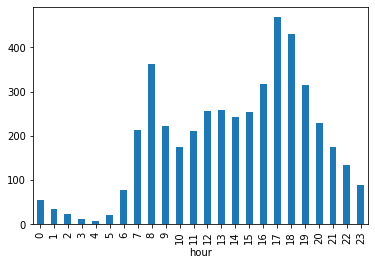

In [6]:
bikes.groupby('hour').total.mean().plot.bar()

In [7]:
bikes.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000


### Análisis descriptivo
Se puede observar que la variable ´workingday´permite ver que en promedio se rentan la misma cantidad de bicicletas dentro de la semana como para los fines de semana, teniendo un cambio que se podría considerar como estadisticamente insignificante.
Por otro lado, la variable ´hour´permite identificar que la renta de bicicletas tiene una distribución notable con respecto a la hora del día. En este caso podemos ver que sobre las 6pm se encuentra la mayor concentración de bicicletas rentadas, mientras que para las horas de la mañana entre 1am a 5 am se encuentra la menor cantidad en promedio de bicicletas rentadas.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

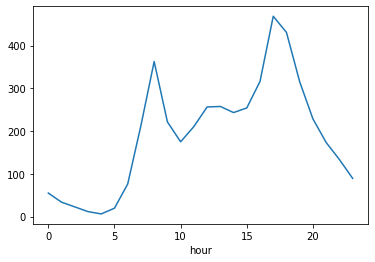

In [8]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

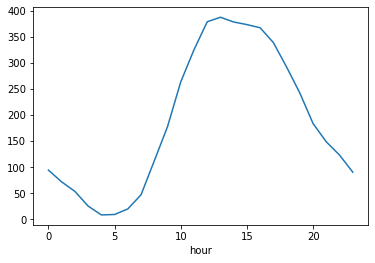

In [9]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
bikes[bikes['workingday']==0].groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

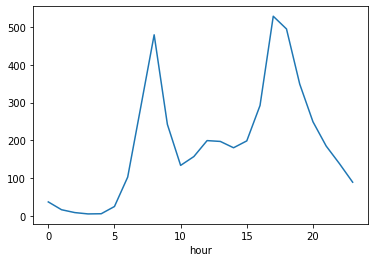

In [10]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
bikes[bikes['workingday']==1].groupby('hour').total.mean().plot()

### Análisis de gráficos
Se puede observar que el comportamiento de la renta de bicicletas para días de la semana se puede comparar con una campana, donde a medida que van siendo las 6 de la tarde van aumentando la cantidad promedio de biciletas rentadas, para posterior a esta hora volver a disminuir.
Por otro lado, cuando se analiza el comportamiento para los fines de semana, se encuentra que hay dos horas pico en las cuales la renta de bicicletas se incrementa fuertemente y esto es lo que le genera un fuerte pico a la gráfica completa. Dichos picos se encuentran a las 8am y a las 6pm-7pm.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [11]:
# Celda 3
from sklearn.model_selection import train_test_split
from sklearn import linear_model
X = bikes[['hour', 'workingday']]
y = bikes['total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)

print('Coefficients: \n', lin_reg.coef_)

Coefficients: 
 [10.5345185   7.72058937]


In [12]:
pd.DataFrame({'feature':X.columns, 'importance':lin_reg.coef_}).sort_values('importance')

,feature,importance
1,workingday,7.720589
0,hour,10.534518


### Análisis de importancias
** Solo con las dos variables pedidas en el enunciado:
Se puede encontrar entonces que como se había comentado anteriormente, la hora tiene un impacto alto sobre la cantdiad de bicicletas rentadas, pues este coeficiente nos dice que por cada aumento en una hora, la cantidad de biciletas rentadas aumenta en promedio por 10.53 bicicletas. Por otro lado, cuando es fin de semana se tienden a rentar 7.7 bicicletas más que cuando es día de semana.


** Con todas las variables:
Se puede encontrar que las variables que parecen ser más importantes de forma positiva para este caso, haciendo uso de una regresión lineal, son las variables registeres y las variables casual. Esto tiene todo el sentido del mundo si se entiende que la suma de estas dos variables debería entenderse como el total de bicicletas rentadas. Por ende, un aumento de 1 en cada una de estas variables termina siendo un aumento de 1 en la variable de salida.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [27]:
def mse_(y):
    if y.shape[0] == 0:
        return 0
    else:
        y_prom = y.mean()
        return np.mean(np.power((y-y_prom),2))

In [28]:
mse_(np.array([1,1,2,3]))

1.75


0.6875

In [34]:
# Celda 4
# Se hace uso de la función que se creó en el laboratorio para desarrollar de forma manual las diferentes particiones manuales del arbol
def mse_(y):
    if y.shape[0] == 0:
        return 999999999999
    else:
        y_prom = y.mean()
        return np.mean(np.power((y-y_prom),2))

def mse_split(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    mse_y = mse_(y)
    mse_l = mse_(y_l)
    mse_r = mse_(y_r)
    
    mse_impurity_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)
    
    return mse_impurity_

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = mse_split(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=6, num_pct=20)

In [35]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [36]:
y_pred = tree_predict(X_test, tree)

In [37]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

69183.90355174526

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [38]:
# Celda 5
from sklearn.tree import DecisionTreeRegressor
arb_lib = DecisionTreeRegressor(random_state = 123, max_depth = 6)
arb_lib.fit(X_train, y_train)
y_pred = arb_lib.predict(X_test)

In [39]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

12165.93009725539

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [40]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [41]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [42]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [49]:
# Celda 6
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []
f1_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=123)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=15, scoring='accuracy').mean())
    f1_scores.append(cross_val_score(clf, X, y, cv=15, scoring='f1').mean())

Text(0, 0.5, 'Accuracy')

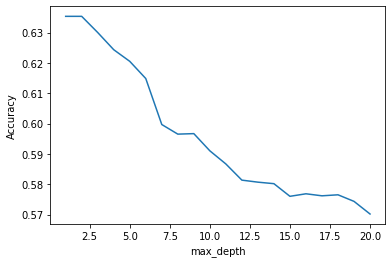

In [50]:
import matplotlib.pyplot as plt
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

Text(0, 0.5, 'F1-Score')

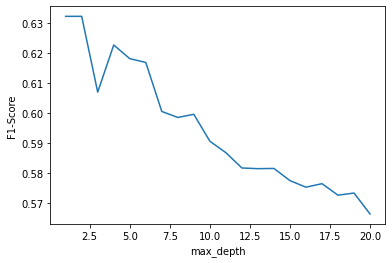

In [51]:
plt.plot(max_depth_range, f1_scores)
plt.xlabel('max_depth')
plt.ylabel('F1-Score')

In [55]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
accu_arb, f1_arb, depth_arb = sorted(zip(accuracy_scores, f1_scores, max_depth_range))[::-1][0]

In [54]:
from sklearn.linear_model import LogisticRegression
reg_log = LogisticRegression()
accu_reg = cross_val_score(reg_log, X, y, cv=15, scoring='accuracy').mean()
f1_reg = cross_val_score(reg_log, X, y, cv=15, scoring='f1').mean()

In [58]:
print('Métricas de desempeño')
print(('-'*20))
print('Accuracy arbol: ', accu_arb)
print('F1 Score arbol: ', f1_arb)
print('Accuracy regresión log: ', accu_reg)
print('F1 Score regresión log: ', f1_reg)

Métricas de desempeño
--------------------
Accuracy arbol:  0.6353333333333334
F1 Score arbol:  0.6322279240282357
Accuracy regresión log:  0.6156666666666666
F1 Score regresión log:  0.6093708245299182


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [65]:
# Celda 7
# Creación de 300 muestras de bootstrap
n_estimators = 300
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

In [66]:
modelos = {}
for i, samp in enumerate(samples):
    if(i < 100):
        modelos[i] = DecisionTreeClassifier(max_depth=None, random_state=seeds[i])
        modelos[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    elif(i < 200):
        modelos[i] = DecisionTreeClassifier(max_depth=2, random_state=seeds[i])
        modelos[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    else:
        modelos[i] = LogisticRegression(random_state=seeds[i])
        modelos[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [67]:
# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = modelos[i].predict(X_test)

In [68]:
# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

In [69]:
# Desempeño al hacer votación mayoritaria
from sklearn import metrics
print('Accuracy modelo ensamblado:', metrics.accuracy_score(y_pred, y_test))
print('F1 Score modelo ensamblado:', metrics.f1_score(y_pred, y_test))

Accuracy modelo ensamblado: 0.636
F1 Score modelo ensamblado: 0.6330645161290323


Mejora un poco con respecto a los estimadores por separado, sin embargo, el aumento no es tan grande como se esperaba que fuera.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [71]:
# Celda 8
samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))

# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = modelos[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()

# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)

y_pred = (weighted_sum_1 >= 0.5).astype(np.int)

In [72]:
# Desempeño al hacer votación mayoritaria
print('Accuracy modelo ensamblado:', metrics.accuracy_score(y_pred, y_test))
print('F1 Score modelo ensamblado:', metrics.f1_score(y_pred, y_test))

Accuracy modelo ensamblado: 0.6333333333333333
F1 Score modelo ensamblado: 0.6278755074424899


Para este caso en particular se presenta un mejor desempeño la metodología de ensamblaje por votación mayoritaria, tal como se muestra en las métricas de desempeño.

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

# Celda 9
Tal y como se ha venido comentando en el desarrollo del notebook, los modelos por si solos de arboles y de regresión logística tienden a tener unas métricas de desempeño inferiores a las que se consiguen al realizar una metodología de ensamblaje, ya que esta metodología busca reducir la varianza final de la predicción. Sin embargo, se logra identificar que para este ejercicio en particular, a pesar de que sí se ve una evidencia de una mejoría en las métricas de desempeño, estas no son significativamente grandes comparadas con el gasto computacional adicional de pasar de entrenar 1 modelo, a tener que entrenar 300 modelos. 